<a href="https://colab.research.google.com/github/drouvotlucas/Isima-challenge/blob/main/challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Challenge Deep Learning

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##Install

In [ ]:
pip install cleanlab

## Imports

In [ ]:
import tensorflow as tf
import tensorflow.keras as tk
from tensorflow import keras
from tensorflow.keras.utils import load_img, img_to_array, to_categorical
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
tf.keras.callbacks.History()
import pandas as pd
import numpy as np
import time
from PIL import Image
import glob
import os
import matplotlib.pyplot as plt
%matplotlib inline
from cleanlab.classification import CleanLearning
from cleanlab.filter import find_label_issues

# Ajouter les imports nécessaires

## Données

###Telechargement données

Etant donné la taille importante du dossier Data_Train_Valid, nous avons fait le choix d'importer uniquement le dossier en .zip dans le drive pour un soucis de temps d'éxecution. Puis nous le dezippons afin de recuperer toutes les données.

In [ ]:
classes = ["basket","eye","binoculars","rabbit","hand"]

!unzip -qq -u "/content/drive/MyDrive/DeepLearning/Data_Train_Valid.zip" -d "/data"

path = "/data"


Nous créons des dataframe avec les données que nous récupérons et que nous séparons en base d'entrainement, de validation et de test.

In [ ]:
def get_data(size_t=None, frac_t=None):

    # Set d'entrainement
    train = pd.read_csv(path + '/train.csv')

    # Validation et test sets
    valid_test_df = pd.read_csv(path + '/valid.csv')

    # Separation des sets validation et test
    if not(size_t==None and frac_t==None): # If we want a test set
        if not(size_t==None):
            # Extraction of size_t element from valid_test_df for each class into our test set
            zero_df = valid_test_df[:5000].sample(n=size_t)
            un_df = valid_test_df[5000:10000].sample(n=size_t)
            deux_df = valid_test_df[10000:15000].sample(n=size_t)
            trois_df = valid_test_df[15000:20000].sample(n=size_t)
            quatre_df = valid_test_df[20000:25000].sample(n=size_t)
        else:
            # Extraction des données pour le dataset d'entrainement
            zero_df = valid_test_df[:5000].sample(frac=frac_t)
            un_df = valid_test_df[5000:10000].sample(frac=frac_t)
            deux_df = valid_test_df[10000:15000].sample(frac=frac_t)
            trois_df = valid_test_df[15000:20000].sample(frac=frac_t)
            quatre_df = valid_test_df[20000:25000].sample(frac=frac_t)

        # Puis concatenation
        test_df = pd.concat(objs=[zero_df, un_df, deux_df, trois_df, quatre_df], axis=0, ignore_index=False)

        ### Extractation du validation set
        test_index = test_df.index
        valid_df = valid_test_df.drop(index=test_index).sample(frac=1)

        ### Reset indexes
        test_df = test_df.reset_index(drop=True)
        valid_df = valid_df.reset_index(drop=True)
        ### Output
        res = (train, valid_df, test_df)

    else:
        res = (train, valid_test_df,)

    print(f"Shape train set dataframe = {res[0].shape}")
    print(f"Shape valid set dataframe = {res[1].shape}")
    try:
        print(f"Shape test set dataframe  = {res[2].shape}")
    except:
        print("No test set.")
        pass

    return res

In [ ]:
train_df, valid_df, test_df = get_data(size_t=None, frac_t=0.5)

Shape train set dataframe = (75000, 3)
Shape valid set dataframe = (12500, 3)
Shape test set dataframe  = (12500, 3)


Nous ajoutons les images sous formes d'array à nos dataframe.

In [ ]:
x_train = np.array([img_to_array(load_img(path + "/images/" + file, color_mode="grayscale")).reshape((28, 28)) for file in train_df['relative_path']])
x_train = x_train.reshape(-1, 28, 28, 1)
y_train = np.array(train_df['class_label'])
y_train = tk.utils.to_categorical(y_train, 5)

x_valid = np.array([img_to_array(load_img(path + "/images/" + file, color_mode="grayscale")).reshape((28, 28)) for file in valid_df['relative_path']])
x_valid = x_valid.reshape(-1, 28, 28, 1)
y_valid = np.array(valid_df['class_label'])
y_valid = tk.utils.to_categorical(y_valid, 5)

x_test = np.array([img_to_array(load_img(path + "/images/" + file, color_mode="grayscale")).reshape((28, 28)) for file in test_df['relative_path']])
x_test = x_test.reshape(-1, 28, 28, 1)
y_test = np.array(test_df['class_label'])
y_test = tk.utils.to_categorical(y_test, 5)

In [ ]:
len(x_train)

75000

###Informations

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75000 entries, 0 to 74999
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   image_name     75000 non-null  object
 1   relative_path  75000 non-null  object
 2   class_label    75000 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


In [ ]:
valid_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12500 entries, 0 to 12499
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   image_name     12500 non-null  object
 1   relative_path  12500 non-null  object
 2   class_label    12500 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 293.1+ KB


### Visualisation de données

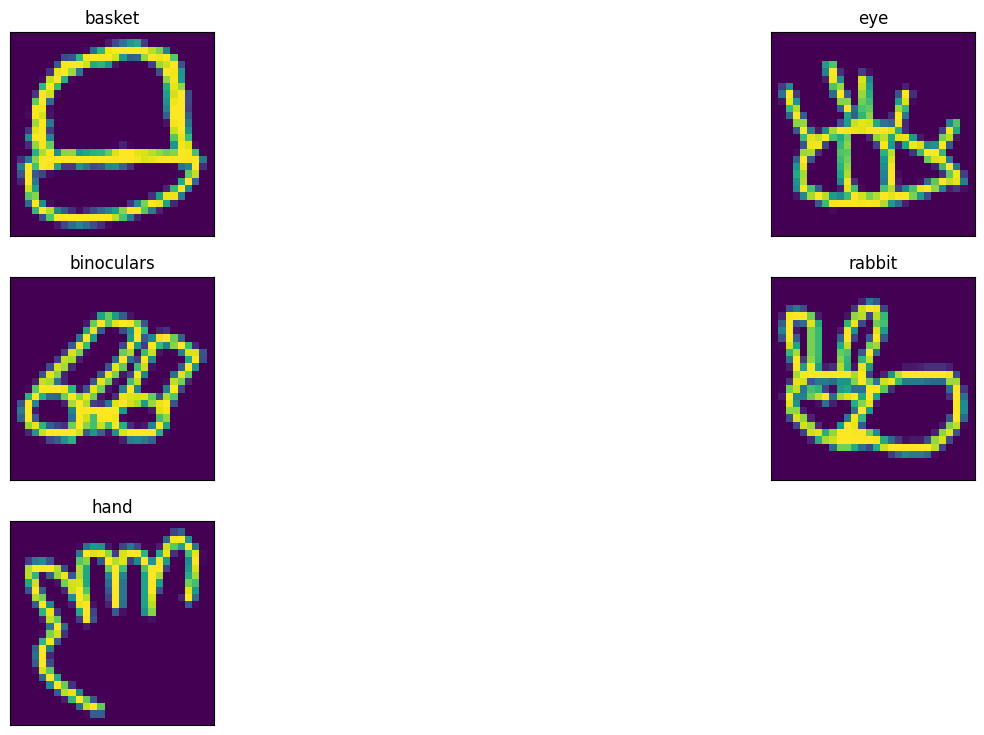

In [ ]:
plt.figure(figsize=(18,9))
for i in range(0,5):
    ax= plt.subplot(3,2 ,i+1)
    mydata = pd.read_csv(path + "/train.csv",skiprows = [1], nrows=1)
    im = Image.open(path + '/images/'+classes[i]+'/'+ os.listdir(path + "/images/"+classes[i])[0])
    fig=ax.imshow(im)
    plt.title(classes[i])
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
plt.show()


##Choix du modèle

Le modèle CNN semble le plus adéquat pour la gestion des images. Nous allons tester ce modèle, le comparer avec d'autres modèles pour etre sur de notre choix puis enfin voir comment nous pouvons l'ameliorer si besoin.

###Fonctions utiles

In [ ]:
def affichage(x,y,id):
  plt.figure(figsize=(30,15))
  nb_ligne = int((len(id) / 15))
  if (len(id) % 15 != 0):
        nb_ligne += 1

  for i in range(len(id)):
    ax = plt.subplot(nb_ligne,15 ,i+1)
    array = np.reshape(x[id[i]], (28, 28))
    image = Image.fromarray(array)
    figure = ax.imshow(image)
    plt.tight_layout()
    plt.title(classes[np.argmax(y[id[i]])])
    figure.axes.get_xaxis().set_visible(False)
    figure.axes.get_yaxis().set_visible(False)

plt.show()

In [ ]:
def train_model(model, x_train, y_train, x_valid, y_valid, epochs=30, batch_size=128, learning_rate=0.01, datagen=None):
    """
    Entraîne le modèle selon les hyperparamètres d'entraînement choisis.

    """

    # Autres paramètres
    METRICS = ['accuracy']
    OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    LOSS = tf.keras.losses.CategoricalCrossentropy()

    # Arrêt si pas d'amélioration
    EARLY_STOP = EarlyStopping(monitor='val_loss',
                               patience=7,
                               mode='min',
                               baseline=None,
                               restore_best_weights=True,
                               verbose=1)

    # Réduis le taux d’apprentissage lorsqu’une mesure a cessé de s’améliorer.
    LR_DECAY = ReduceLROnPlateau(monitor = 'val_loss',
                                 factor = 0.5,
                                 patience = 2,
                                 min_lr = 1e-15,
                                 mode = 'min',
                                 verbose = 1)

    # Compilation
    model.compile(optimizer=OPTIMIZER, loss=LOSS, metrics=METRICS)

    # Affichage
    print(f"Training data   : {x_train.shape[0]}")
    print(f"Validation data : {x_valid.shape[0]}")

    # Entrainement
    if (datagen != None):
        hist = model.fit(datagen.flow(x_train, y_train, batch_size=batch_size),
                                   validation_data = (x_valid, y_valid),
                                   epochs = epochs,
                                   callbacks=[EARLY_STOP, LR_DECAY])
    else:
        hist = model.fit(x=x_train, y=y_train,
                        validation_data=(x_valid, y_valid),
                        epochs=epochs,
                        batch_size=batch_size,
                        callbacks=[EARLY_STOP, LR_DECAY])

    print(f"Training data   : {x_train.shape[0]}")
    print(f"Validation data : {x_valid.shape[0]}")

    return hist

### 1er modèle CNN

In [ ]:
def basic_CNN_model(summary=True):
    # Definition
    # On ajoute des couches de normalisation et de dropout regularisation pour affiner notre modèle CNN basique

    model = Sequential(name='Basic_CNN')

    # Convolutionnal block 1
    model.add(Conv2D(filters=32, kernel_size=3, padding='same', input_shape=(28, 28, 1)))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(SpatialDropout2D(rate=0.1))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Convolutionnal block 2
    model.add(Conv2D(filters=64, kernel_size=3, padding='same'))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(SpatialDropout2D(rate=0.4))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Flatten
    model.add(Flatten())

    # Dense block
    model.add(Dense(units=256))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(Dropout(rate = 0.6))

    # Output layer
    model.add(Dense(units=5, activation=tf.keras.activations.softmax))

    if (summary):
        model.summary()

    return model

In [ ]:
basic_CNN = basic_CNN_model(summary=True)

Model: "Basic_CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 32)       128       
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 28, 28, 32)        0         
                                                                 
 spatial_dropout2d (SpatialD  (None, 28, 28, 32)       0         
 ropout2D)                                                       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                         

In [ ]:
hist_basicCNN = train_model(basic_CNN, x_train, y_train, x_valid, y_valid, epochs=30, batch_size=128, learning_rate=0.001)

Training data   : 75000
Validation data : 12500
*** Training without data augmentation. ***

Epoch 1/30
586/586 [==============================] - 189s 318ms/step - loss: 0.4711 - accuracy: 0.8473 - val_loss: 0.2428 - val_accuracy: 0.9223 - lr: 0.0010
Epoch 2/30
586/586 [==============================] - 168s 287ms/step - loss: 0.3036 - accuracy: 0.9041 - val_loss: 0.2074 - val_accuracy: 0.9338 - lr: 0.0010
Epoch 3/30
586/586 [==============================] - 163s 278ms/step - loss: 0.2642 - accuracy: 0.9162 - val_loss: 0.1834 - val_accuracy: 0.9412 - lr: 0.0010
Epoch 4/30
586/586 [==============================] - 164s 279ms/step - loss: 0.2340 - accuracy: 0.9245 - val_loss: 0.1672 - val_accuracy: 0.9442 - lr: 0.0010
Epoch 5/30
586/586 [==============================] - 171s 291ms/step - loss: 0.2169 - accuracy: 0.9297 - val_loss: 0.1585 - val_accuracy: 0.9478 - lr: 0.0010
Epoch 6/30
586/586 [==============================] - 161s 276ms/step - loss: 0.2042 - accuracy: 0.9330 - val_lo

Test set size : 12500

391/391 [==============================] - 8s 20ms/step - loss: 0.1337 - accuracy: 0.9570


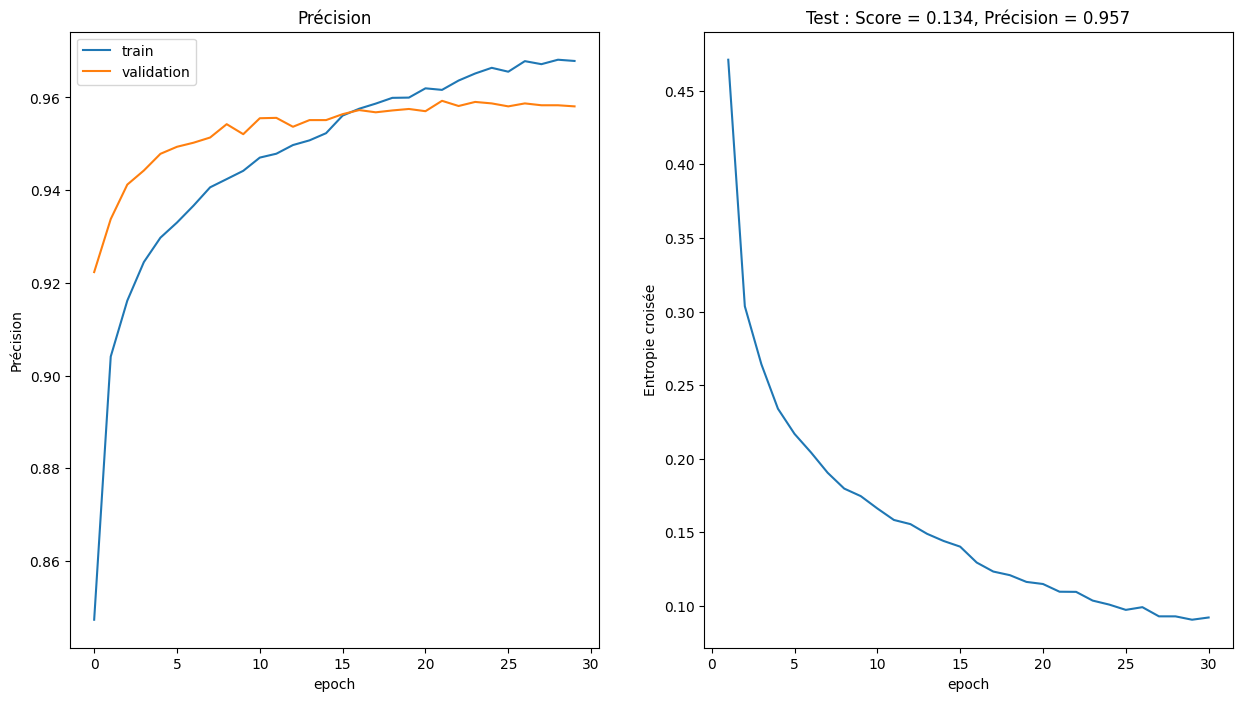

<Figure size 640x480 with 0 Axes>

In [ ]:
# Test sur le dataset d'entrainement
print(f"Test set size : {x_test.shape[0]}\n")
basic_CNN.evaluate(x_test, y_test)
plt.figure(figsize=(15,8))
plt.subplot(1,2,1)
plt.plot(hist_basicCNN.history['accuracy'])
plt.plot(hist_basicCNN.history['val_accuracy'])
plt.title('Précision')
plt.ylabel('Précision')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='best')

plt.subplot(1,2,2)
x = list(range(1,31))
l = hist_basicCNN.history['loss']
plt.xlabel('epoch')
plt.ylabel('Entropie croisée')
plt.title("Test : Score = {0:5.3f}, Précision = {1:5.3f}".format(score[0], score[1]))
plt.plot(x,l)
plt.show()
plt.tight_layout()

In [ ]:
# Enregistrement du modèle
basic_CNN.save('basic_CNN.h5')
basic_CNN.save('/content/drive/MyDrive/DeepLearning/challenge.ipynb/basic_CNN.h5')

On remarque une précision assez bonne sur la base de validation cependant au bout d'un certain nombre d'epoques on constate un léger surapprentissage.

###Comparaison avec PCM pour verification

In [ ]:
# Taille des batchs par apprentissage
batch_size = 100

# Taille de la couche cachée
num_hidden = 10

# Nombre d'itérations
num_epochs = 100

# learning rate
lr = 0.01

In [ ]:
model_PCM = Sequential()
model_PCM.add(Dense(input_shape=(28, 28, 1), units=num_hidden, activation='tanh', name='hidden_layer'))
model_PCM.add(Flatten())
model_PCM.add(Dense(units=5, activation=tf.keras.activations.softmax))
model_PCM.build()
model_PCM.summary()


Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden_layer (Dense)        (None, 28, 28, 10)        20        
                                                                 
 flatten_1 (Flatten)         (None, 7840)              0         
                                                                 
 dense_3 (Dense)             (None, 5)                 39205     
                                                                 
Total params: 39,225
Trainable params: 39,225
Non-trainable params: 0
_________________________________________________________________


In [ ]:
hist_PCM = train_model(model_PCM, x_train, y_train, x_valid, y_valid, epochs=num_epochs, batch_size=128, learning_rate=0.001)

Training data   : 75000
Validation data : 12500
*** Training without data augmentation. ***

Epoch 1/100
586/586 [==============================] - 10s 16ms/step - loss: 0.8117 - accuracy: 0.7208 - val_loss: 0.7802 - val_accuracy: 0.7252 - lr: 0.0010
Epoch 2/100
586/586 [==============================] - 8s 13ms/step - loss: 0.7284 - accuracy: 0.7545 - val_loss: 0.7034 - val_accuracy: 0.7623 - lr: 0.0010
Epoch 3/100
586/586 [==============================] - 10s 17ms/step - loss: 0.6988 - accuracy: 0.7644 - val_loss: 0.6954 - val_accuracy: 0.7702 - lr: 0.0010
Epoch 4/100
586/586 [==============================] - 7s 12ms/step - loss: 0.6881 - accuracy: 0.7684 - val_loss: 0.7148 - val_accuracy: 0.7642 - lr: 0.0010
Epoch 5/100
586/586 [==============================] - 10s 16ms/step - loss: 0.6820 - accuracy: 0.7713 - val_loss: 0.6702 - val_accuracy: 0.7763 - lr: 0.0010
Epoch 6/100
586/586 [==============================] - 7s 13ms/step - loss: 0.6723 - accuracy: 0.7752 - val_loss: 0.674

Test set size : 12500

391/391 [==============================] - 1s 4ms/step - loss: 0.6344 - accuracy: 0.7941


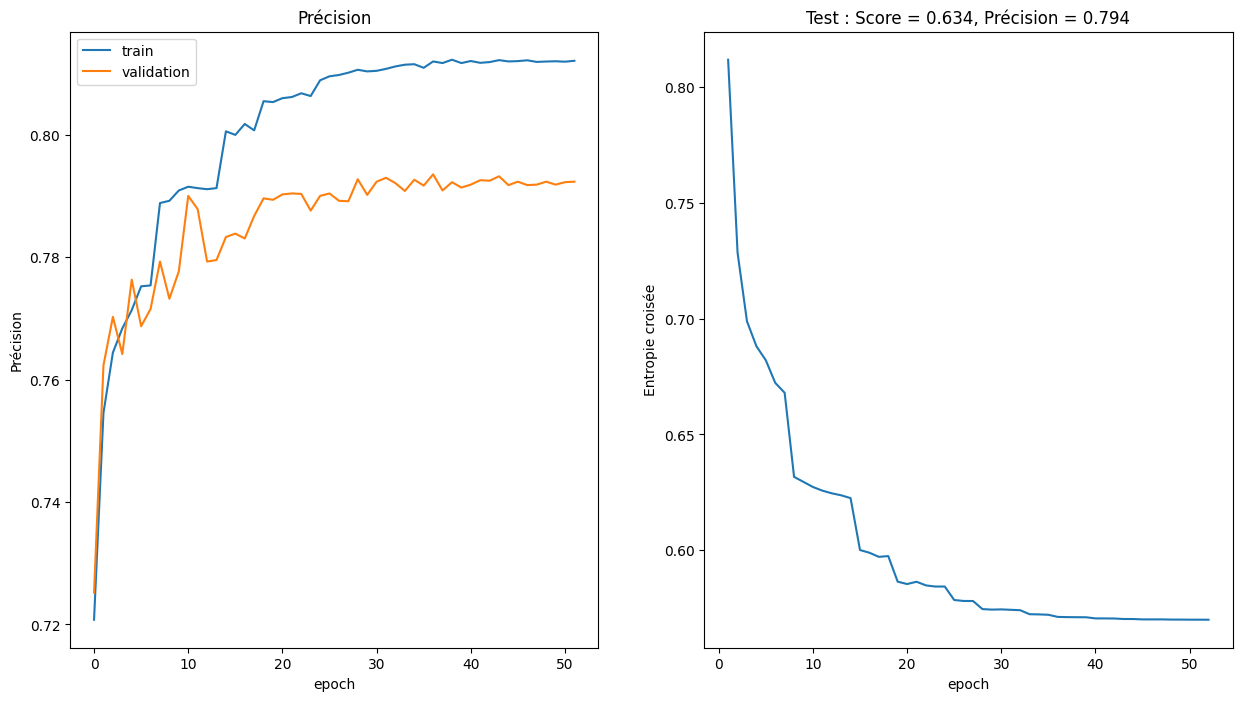

<Figure size 640x480 with 0 Axes>

In [ ]:
# Test sur le dataset d'entrainement
print(f"Test set size : {x_test.shape[0]}\n")
model_PCM.evaluate(x_test, y_test)
plt.figure(figsize=(15,8))
plt.subplot(1,2,1)
plt.plot(hist_PCM.history['accuracy'])
plt.plot(hist_PCM.history['val_accuracy'])
plt.title('Précision')
plt.ylabel('Précision')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='best')

plt.subplot(1,2,2)
x = list(range(1,53))
l = hist_PCM.history['loss']
plt.xlabel('epoch')
plt.ylabel('Entropie croisée')
plt.title("Test : Score = 0.634, Précision = 0.794")
plt.plot(x,l)
plt.show()
plt.tight_layout()

In [ ]:
# Enregistrement du modèle
model_PCM.save('model_PCM.h5')
model_PCM.save('/content/drive/MyDrive/DeepLearning/challenge.ipynb/model_PCM.h5')

On voit bien que le modèle PCM n'est pas du tout adapté à la gestion d'image comme prévu et nous donne une précision de seulement 0.794 comparé au 0.957 donné par le CNN qui est un modèle largement utilisé pour la gestion d'images.

Nous allons donc chercher à ameliorer ce modèle afin d'augmenter sa précision sur notre jeu de donnée.

##Amélioration du CNN


###Amélioration du jeu de donnée

####Géneration de nouvelles données

Nous allons utiliser la méthode de data augmentation vu en cours pour avoir plus de données d'entrainement

In [ ]:
CNN_amelioration1 = basic_CNN_model(summary=False)

datagen = ImageDataGenerator(rotation_range=30,
                             zoom_range = 0.2,
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             fill_mode='nearest')



In [ ]:
hist_CNN_amelioration1 = train_model(CNN_amelioration1, x_train, y_train, x_valid, y_valid, epochs= 30, datagen=datagen)

Test set size : 12500

391/391 [==============================] - 6s 15ms/step - loss: 0.1602 - accuracy: 0.9467


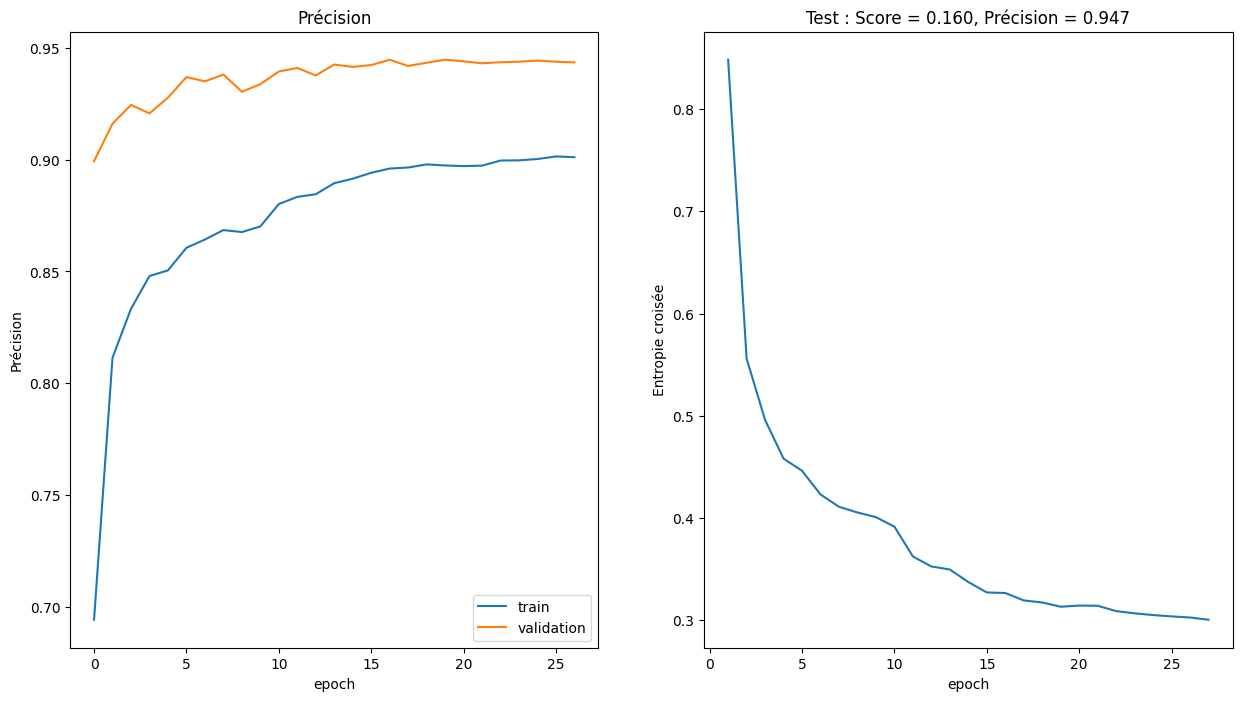

<Figure size 640x480 with 0 Axes>

In [ ]:
# Test sur le dataset d'entrainement
print(f"Test set size : {x_test.shape[0]}\n")
CNN_amelioration1.evaluate(x_test, y_test)
plt.figure(figsize=(15,8))
plt.subplot(1,2,1)
plt.plot(hist_CNN_amelioration1.history['accuracy'])
plt.plot(hist_CNN_amelioration1.history['val_accuracy'])
plt.title('Précision')
plt.ylabel('Précision')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='best')

plt.subplot(1,2,2)
x = list(range(1,28))
l = hist_CNN_amelioration1.history['loss']
plt.xlabel('epoch')
plt.ylabel('Entropie croisée')
plt.title("Test : Score = 0.160, Précision = 0.947".format(score[0], score[1]))
plt.plot(x,l)
plt.show()
plt.tight_layout()

In [ ]:
# Enregistrement du modèle
CNN_amelioration1.save('CNN_amelioration1.h5')
CNN_amelioration1.save('/content/drive/MyDrive/DeepLearning/challenge.ipynb/CNN_amelioration1.h5')

On remarque une première amélioration par rapport au CNN précédent, on obtient une précision similaire sur les données de validation, bien que légèrement plus basse, mais nous n'avons plus le problème de surapprentissage. De plus nous sommes convaincu que sur de nouvelles données le fait de faire de la data augmentation ne pourra apporter que du positif à notre modèle. Nous choisons donc de garder ce modèle.

####Observation et nettoyage de données

Nous utilisons cleanlab pour essayer de nettoyer les données d'entrainement afin d'avoir le modèle le plus précis possible.

In [ ]:
model_cnn = load_model("/content/drive/MyDrive/DeepLearning/challenge.ipynb/CNN_amelioration1.h5")
pred_train = model_cnn.predict(x_train)
pred_valid = model_cnn.predict(x_valid)
pred_test = model_cnn.predict(x_test)

labels_train = []
for i in range(y_train.shape[0]):
      labels_train.append(np.argmax(y_train[i]))
labels_valid = []
for i in range(y_valid.shape[0]):
      labels_valid.append(np.argmax(y_valid[i]))
labels_test = []
for i in range(y_test.shape[0]):
    labels_test.append(np.argmax(y_test[i]))

#utilisation de cleanlab pour trouver les données erronées
id_erronee_train = find_label_issues(labels=labels_train,
                                    pred_probs=pred_train,
                                    return_indices_ranked_by='self_confidence')
id_erronee_valid = find_label_issues(labels=labels_valid,
                                    pred_probs=pred_valid,
                                    return_indices_ranked_by='self_confidence')
id_erronee_test = find_label_issues(labels=labels_test,
                                    pred_probs=pred_test,
                                    return_indices_ranked_by='self_confidence')

#on supprime ces images

x_train_cleaned = np.delete(x_train, id_erronee_train, axis=0)
y_train_cleaned = np.delete(y_train, id_erronee_train, axis=0)
x_valid_cleaned = np.delete(x_valid, id_erronee_valid, axis=0)
y_valid_cleaned = np.delete(y_valid, id_erronee_valid, axis=0)
x_test_cleaned = np.delete(x_test, id_erronee_test, axis=0)
y_test_cleaned = np.delete(y_test, id_erronee_test, axis=0)

391/391 [==============================] - 8s 20ms/step


In [ ]:
len(x_train_cleaned)

74524

<ipython-input-21-13e2cfea5c92>:8: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(nb_ligne,15 ,i+1)


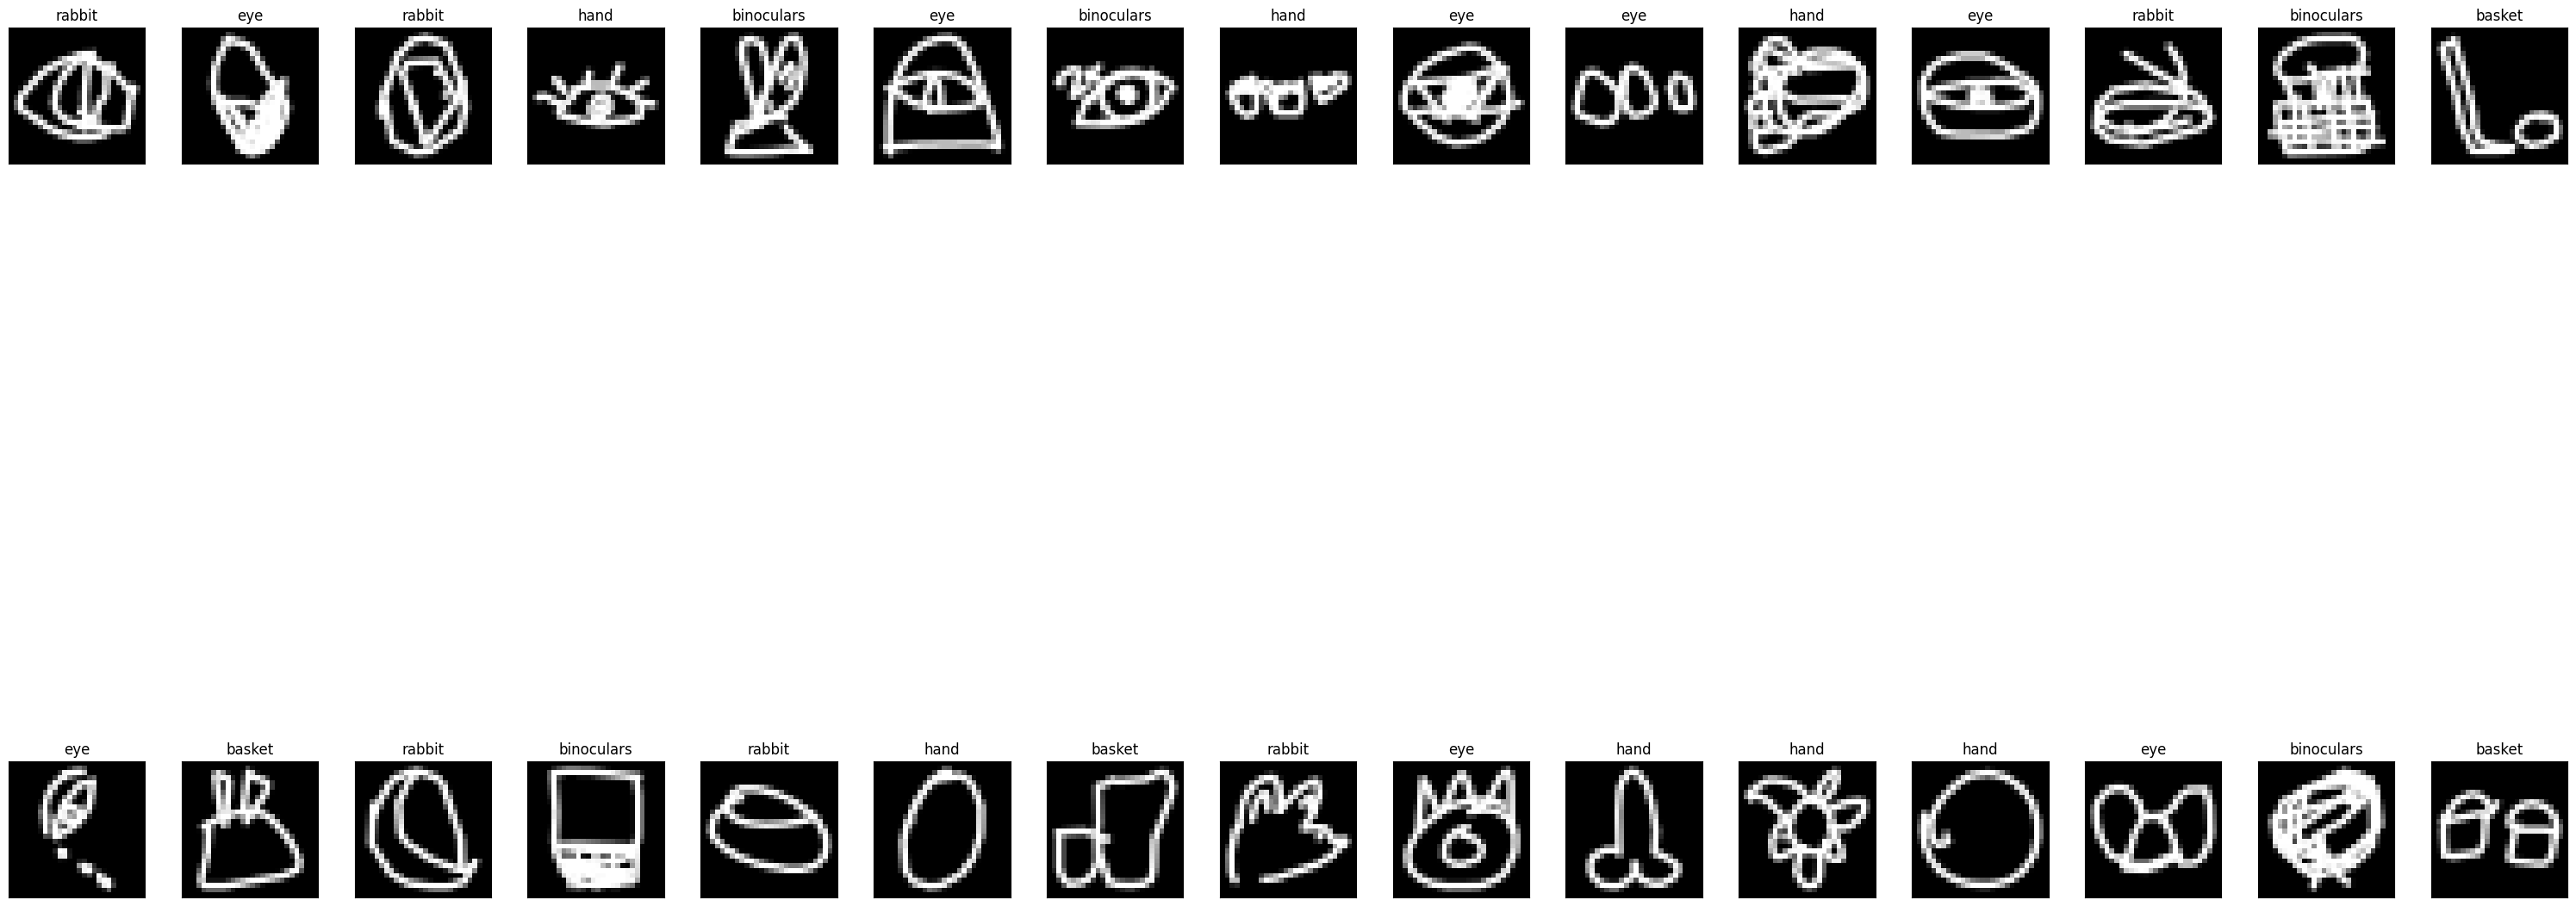

In [ ]:
affichage(x=x_train, y=y_train, id=id_erronee_train[0:30])

<ipython-input-21-13e2cfea5c92>:8: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(nb_ligne,15 ,i+1)


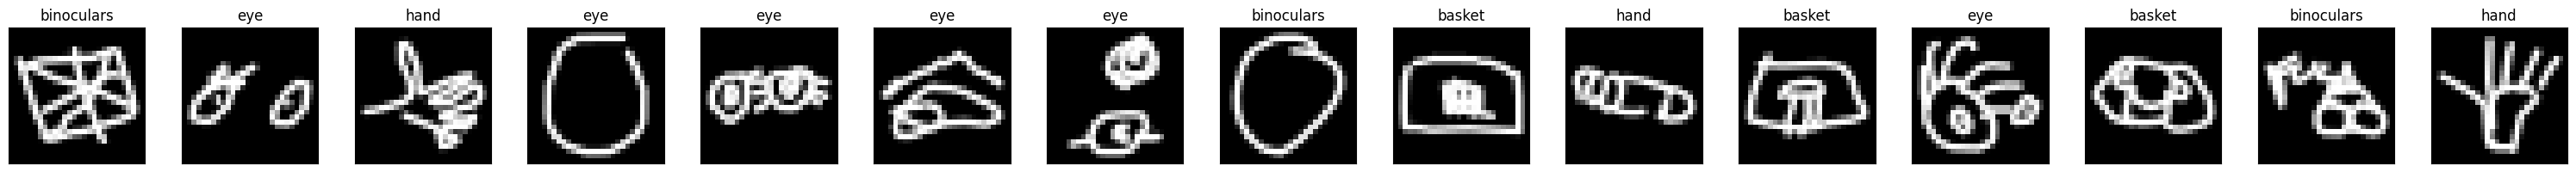

In [ ]:
affichage(x=x_valid, y=y_valid, id=id_erronee_valid[0:30])

<ipython-input-21-13e2cfea5c92>:8: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(nb_ligne,15 ,i+1)


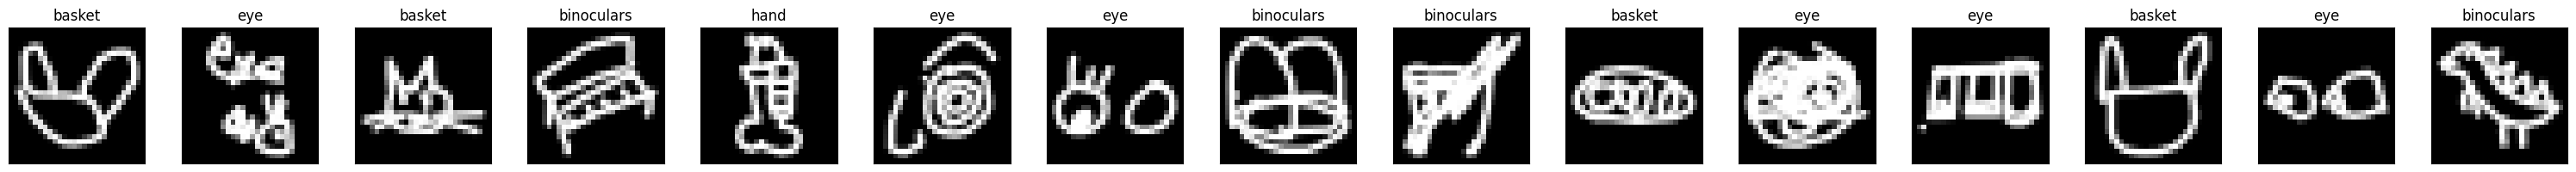

In [ ]:
affichage(x=x_test, y=y_test, id=id_erronee_test[0:30])

On peut voir que Cleanlab a majoritairement supprimé des images qui ne sont pas cohérentes mais il y en a quelques une qui peuvent se rapprocher du résultat attendu cependant elles sont mal dessinées. Cela ne represente pas une majeur partie de nos données, on décide donc de les supprimer pour voir si cela augmente la précision de notre modèle.

Nous allons utiliser la méthode de data augmentation vu précedemment sur ce nouveau jeu de donnée nettoyé

In [ ]:
CNN_amelioration2 = basic_CNN_model(summary=False)

datagen = ImageDataGenerator(rotation_range=30,
                             zoom_range = 0.2,
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             fill_mode='nearest')

hist_CNN_amelioration2 = train_model(CNN_amelioration2, x_train_cleaned, y_train_cleaned, x_valid_cleaned, y_valid_cleaned, epochs= 30, datagen=datagen)

Training data   : 74992
Validation data : 12436
Epoch 1/30
586/586 [==============================] - 190s 321ms/step - loss: 0.8484 - accuracy: 0.6953 - val_loss: 0.2975 - val_accuracy: 0.9046 - lr: 0.0100
Epoch 2/30
586/586 [==============================] - 191s 326ms/step - loss: 0.5514 - accuracy: 0.8143 - val_loss: 0.3046 - val_accuracy: 0.9073 - lr: 0.0100
Epoch 3/30
586/586 [==============================] - 191s 325ms/step - loss: 0.4884 - accuracy: 0.8373 - val_loss: 0.2204 - val_accuracy: 0.9263 - lr: 0.0100
Epoch 4/30
586/586 [==============================] - 185s 316ms/step - loss: 0.4600 - accuracy: 0.8477 - val_loss: 0.1981 - val_accuracy: 0.9340 - lr: 0.0100
Epoch 5/30
586/586 [==============================] - 191s 326ms/step - loss: 0.4371 - accuracy: 0.8546 - val_loss: 0.1802 - val_accuracy: 0.9366 - lr: 0.0100
Epoch 6/30
586/586 [==============================] - 190s 324ms/step - loss: 0.4208 - accuracy: 0.8595 - val_loss: 0.1829 - val_accuracy: 0.9386 - lr: 0.010

Test set size : 12500

389/389 [==============================] - 14s 36ms/step - loss: 0.1365 - accuracy: 0.9510


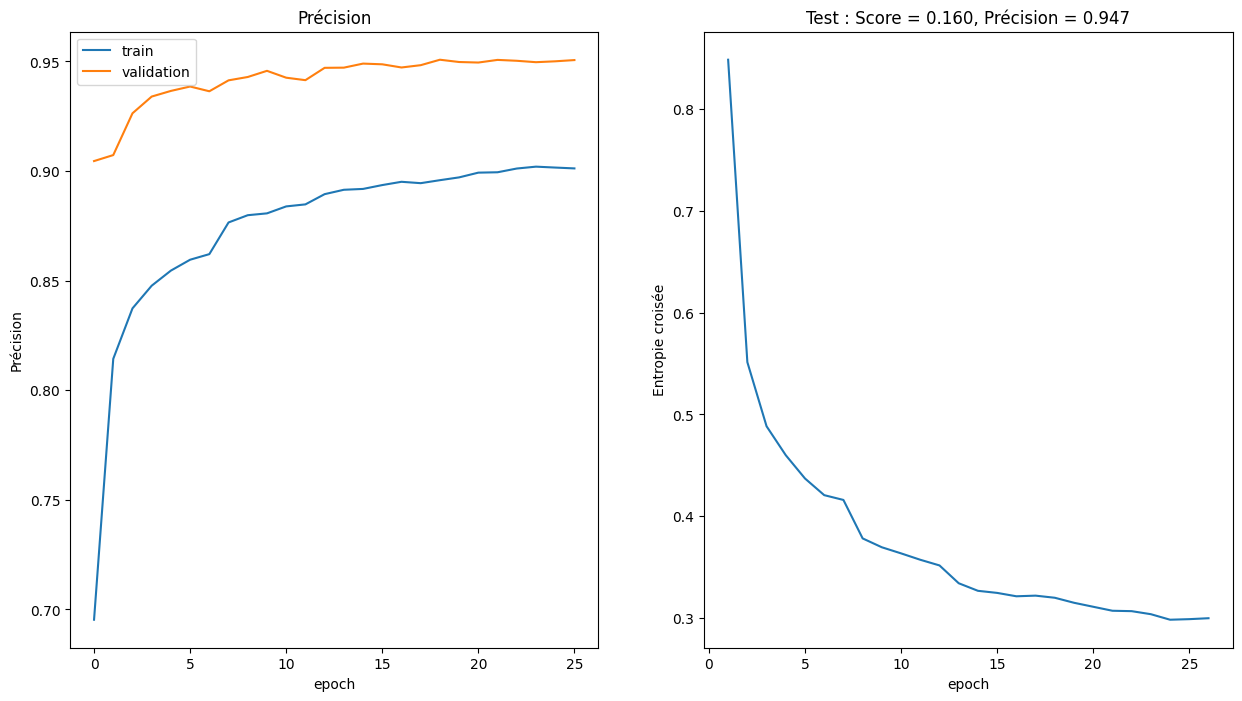

<Figure size 640x480 with 0 Axes>

In [ ]:
# Test sur le dataset d'entrainement
print(f"Test set size : {x_test.shape[0]}\n")
CNN_amelioration2.evaluate(x_test_cleaned, y_test_cleaned)
plt.figure(figsize=(15,8))
plt.subplot(1,2,1)
plt.plot(hist_CNN_amelioration2.history['accuracy'])
plt.plot(hist_CNN_amelioration2.history['val_accuracy'])
plt.title('Précision')
plt.ylabel('Précision')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='best')

plt.subplot(1,2,2)
x = list(range(1,27))
l = hist_CNN_amelioration2.history['loss']
plt.xlabel('epoch')
plt.ylabel('Entropie croisée')
plt.title("Test : Score = 0.137, Précision = 0.951".format(score[0], score[1]))
plt.plot(x,l)
plt.show()
plt.tight_layout()

In [ ]:
# Enregistrement du modèle
CNN_amelioration2.save('CNN_amelioration2.h5')
CNN_amelioration2.save('/content/drive/MyDrive/DeepLearning/challenge.ipynb/CNN_amelioration2.h5')

On remarque que l'on gagne en précision lorsque l'on effectue notre apprentissage après le nettoyage de données, tout en continuant d'éviter le surapprentissage.

###Amélioration du modèle part la combinaison de celui-ci et d'un RNN

Nous avons voulu tester d'améliorer notre modèle en le combinant avec un reseau de type RNN, les RNN sont spécialisés dans des tâches où il est important de prendre en compte le temps. Ils ne sont donc pas construits pour la reconnaissance d'images mais nous avons voulu voir si ils pouvaient apporter quelque chose a notre CNN qui lui est connu pour avoir de bon résultats en reconnaissance d'images.

In [ ]:
lstm_model = Sequential()

input_shape = (28, 28, 1)

cnn_model = load_model("/content/drive/MyDrive/DeepLearning/challenge.ipynb/CNN_amelioration2.h5")
# Create a new model to avoid modifying the pre-trained model directly
combined_model = Sequential(name='Combined_CNN_LSTM')

# Add the pre-trained CNN model
combined_model.add(cnn_model)

# Reshape the output of the CNN model to be compatible with LSTM input
combined_model.add(Reshape((1, cnn_model.output_shape[1])))

# Define the LSTM model
lstm_model = Sequential(name='LSTM_Model')
lstm_model.add(LSTM(128, input_shape=(1, cnn_model.output_shape[1])))

# Add the LSTM model to the combined model
combined_model.add(lstm_model)

# Output layer
combined_model.add(Dense(units=5, activation='softmax'))

# Display the combined model structure
combined_model.summary()

Model: "Combined_CNN_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Basic_CNN (Sequential)      (None, 5)                 824581    
                                                                 
 reshape (Reshape)           (None, 1, 5)              0         
                                                                 
 LSTM_Model (Sequential)     (None, 128)               68608     
                                                                 
 dense_4 (Dense)             (None, 5)                 645       
                                                                 
Total params: 893,834
Trainable params: 893,130
Non-trainable params: 704
_________________________________________________________________


In [ ]:
hist_combined_model = train_model(combined_model, x_train_cleaned, y_train_cleaned, x_valid_cleaned, y_valid_cleaned, epochs=30, batch_size=128, learning_rate=0.001, datagen = datagen)

Training data   : 74524
Validation data : 12392
Epoch 1/30
583/583 [==============================] - 221s 371ms/step - loss: 0.5579 - accuracy: 0.8930 - val_loss: 0.1686 - val_accuracy: 0.9531 - lr: 0.0010
Epoch 2/30
583/583 [==============================] - 197s 338ms/step - loss: 0.3107 - accuracy: 0.9034 - val_loss: 0.1478 - val_accuracy: 0.9545 - lr: 0.0010
Epoch 3/30
583/583 [==============================] - 201s 344ms/step - loss: 0.3038 - accuracy: 0.9023 - val_loss: 0.1423 - val_accuracy: 0.9546 - lr: 0.0010
Epoch 4/30
583/583 [==============================] - 193s 331ms/step - loss: 0.2967 - accuracy: 0.9040 - val_loss: 0.1388 - val_accuracy: 0.9555 - lr: 0.0010
Epoch 5/30
583/583 [==============================] - 199s 341ms/step - loss: 0.2930 - accuracy: 0.9043 - val_loss: 0.1368 - val_accuracy: 0.9549 - lr: 0.0010
Epoch 6/30
583/583 [==============================] - 201s 345ms/step - loss: 0.2944 - accuracy: 0.9046 - val_loss: 0.1335 - val_accuracy: 0.9553 - lr: 0.001

Test set size : 12500

389/389 [==============================] - 11s 27ms/step - loss: 0.1317 - accuracy: 0.9526


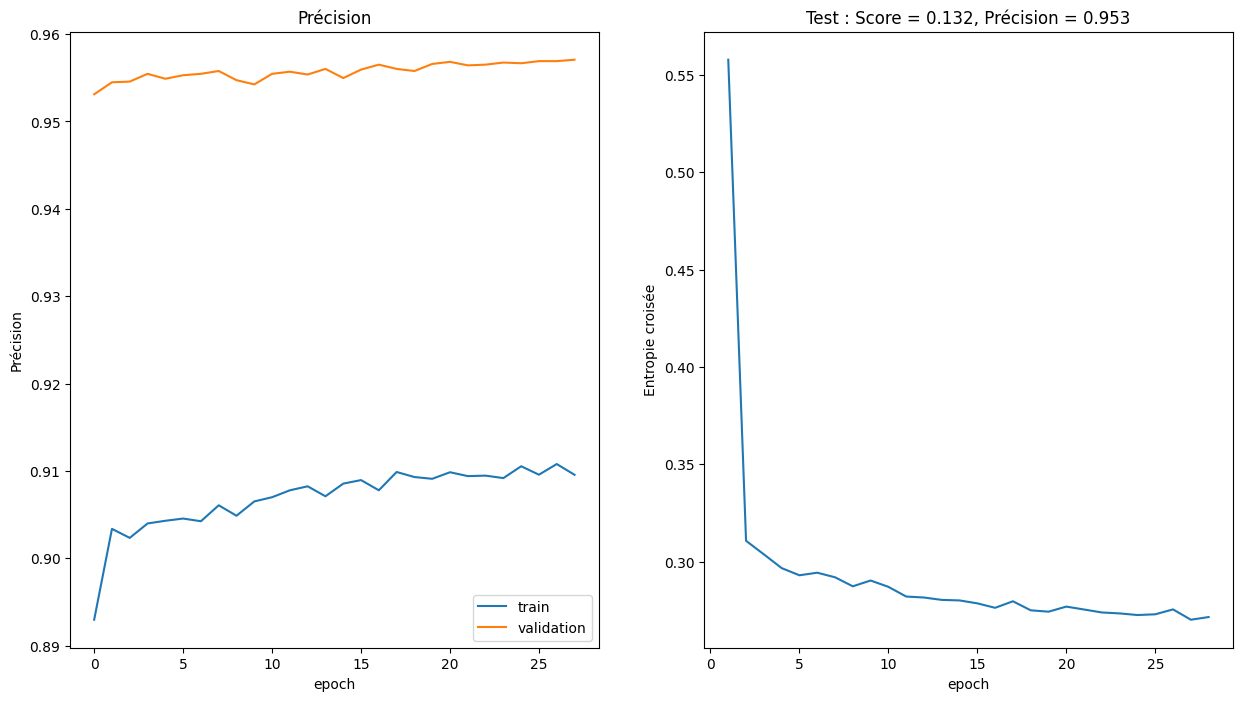

<Figure size 640x480 with 0 Axes>

In [ ]:
print(f"Test set size : {x_test.shape[0]}\n")
combined_model.evaluate(x_test_cleaned, y_test_cleaned)
plt.figure(figsize=(15,8))
plt.subplot(1,2,1)
plt.plot(hist_combined_model.history['accuracy'])
plt.plot(hist_combined_model.history['val_accuracy'])
plt.title('Précision')
plt.ylabel('Précision')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='best')

plt.subplot(1,2,2)
x = list(range(1,29))
l = hist_combined_model.history['loss']
plt.xlabel('epoch')
plt.ylabel('Entropie croisée')
plt.title("Test : Score = 0.132, Précision = 0.953")
plt.plot(x,l)
plt.show()
plt.tight_layout()

In [ ]:
# Enregistrement du modèle
combined_model.save('combined_model.h5')
combined_model.save('/content/drive/MyDrive/DeepLearning/challenge.ipynb/combined_model.h5')

Nous remarquons une légère amélioration de la précision après la combinaison entre les deux réseaux. Il est plus précis des les premières époques sur la base de validation. Nous avons donc finallement choisi de selectionner ce modèle qui nous parrait le plus adapté à notre problème.

In [ ]:
pip freeze > /content/drive/MyDrive/DeepLearning/challenge.ipynb/requirements.txt